In [2]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

from photutils.datasets import make_100gaussians_image
from photutils.background import Background2D, MedianBackground

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel

from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection
from lvmagp.focus.focusseries import ProjectionFocusSeries, PhotometryFocusSeries

from photutils.centroids import centroid_quadratic

from plotimg import plot_images


In [3]:
from plotimg import plot_images

async def focus_calc(focus, radius_data, images, source_detection):

    for idx, img in enumerate(images):
        images[idx].data = median_filter(images[idx].data, size=2)
        
        # photutils.background
        bkg_estimator = MedianBackground()
        bkg = Background2D(img.data.astype(float), (50, 50), filter_size=(3, 3),
                           bkg_estimator=bkg_estimator)
        images[idx].data = images[idx].data.astype(float) - bkg.background
        bkg_median = np.median(bkg.background)
        bkg_std = np.std(bkg.background)

        # sep.background
#        bkg = sep.Background(images[idx].data.astype(float))
#        images[idx].data = images[idx].data.astype(float) - bkg
#        bkg_median = np.median(bkg)
#        bkg_std = np.std(bkg_median)
        
#        print(f"median {bkg_median}, std {bkg_std}")
   
    for idx, img in enumerate(images):
        images[idx] = await source_detection(img)
#        images[idx].catalog.sort("fwhm")
        images[idx].catalog = images[idx].catalog[images[idx].catalog["peak"] > bkg_median + (1 * bkg_std) ]
#        images[idx].catalog = images[idx].catalog[images[idx].catalog["ellipticity"] < 0.3]
        images[idx].catalog.sort("flux")
        images[idx].catalog.reverse()

        sources = images[idx].catalog
        if (len(sources) > 2):
            radius = np.median(sources[column][:num_stars])
            radius_err = np.std(sources[column][:num_stars])
            radius_data[idx].append({"focus": focus, "r": radius, "rerr": radius_err})

    plot_images(images, cat_max=num_stars, cat_rest=True,)

    return radius_data


In [5]:
from typing import List, Tuple
from scipy.optimize import curve_fit


def fit_hyperbola(x_arr: List[float], y_arr: List[float], y_err: List[float]) -> Tuple[float, float]:
    """Fit a hyperbola

    Args:
        x_arr: X data
        y_arr: Y data
        y_err: Y errors

    Returns:
        Minimum of hyperbola and its uncertainty
    """

    # initial guess
    ic = np.argmin(y_arr)
    ix = np.argmax(y_arr)
    b = y_arr[ic]
    c = x_arr[ic]
    x = x_arr[ix]
    slope = np.abs((y_arr[ic] - y_arr[ix]) / (c - x))
    a = b / slope

    # init
    p0 = [a, b, c]

    # fit
    coeffs, cov = curve_fit(
        lambda xx, aa, bb, cc: bb * np.sqrt((xx - cc) ** 2 / aa**2 + 1.0), x_arr, y_arr, sigma=y_err, p0=p0
    )

    # return result
    return coeffs[2], cov[2][2]


In [6]:
#from lvmagp.focus.curvefit import fit_hyperbola

def focus_plot(images, data):
    #print(data)

    fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(8, 5/len(data)))

    for idx, dd in enumerate(data):
        focus = [d["focus"] for d in dd]
        r = [d["r"] for d in dd]
        rerr = [d["rerr"] for d in dd]

        ax_idx = ax[idx] if len(data) > 1 else ax
        ax_idx.set_title(images[idx].header["CAMNAME"])
        ax_idx.errorbar(focus, r, yerr=rerr)

        fit_focus, fit_err = fit_hyperbola(focus, r, rerr)
        print(f"focus: {fit_focus}, {fit_err}")


In [ ]:
%matplotlib inline
#%matplotlib widget

off=400
num=15

off=404
num=5

off=391
num=7

off=392
num=5

#off=319 # to short 36 - 38, 0.5
#num=5

#off=329 #bad
#num=5

off=392
num=5

threshold = 1.2
minarea = 24.0
deblend_nthresh = 1.4

num_stars = 7

source_detection = SepSourceDetection(threshold= threshold, minarea=minarea, deblend_nthresh=deblend_nthresh)
column = "fwhm"

radius_data = [[]]

fbase = lambda idx: f"/data/lvm/sci/agcam/east/20221028n/lvm.sci.agcam.east_{idx:08}.fits"

for i in range(num):
    images = [Image.from_file(fbase(i+off))]
    focus = images[0].header["FOCUSUM"]
#    print(images[0].header)
    print(f" focus: {focus} exptime: {images[0].header['EXPTIME']} file: {fbase(i+off)}")

    await focus_calc(focus, radius_data, images, source_detection)

focus_plot(images, radius_data)

 focus: 39.4 file: ['/data/lvm/sci/agcam/east/20221108/lvm.sci.agcam.east_00000931.fits', '/data/lvm/sci/agcam/west/20221108/lvm.sci.agcam.west_00000931.fits']


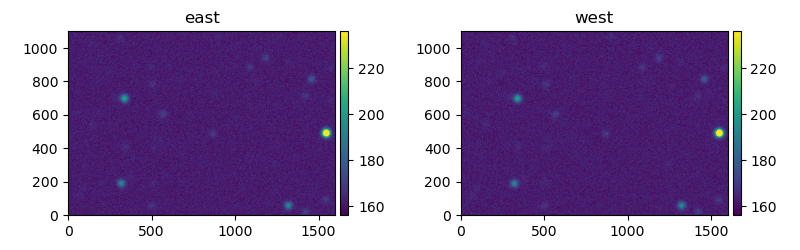

 focus: 40.233333333333334 file: ['/data/lvm/sci/agcam/east/20221108/lvm.sci.agcam.east_00000932.fits', '/data/lvm/sci/agcam/west/20221108/lvm.sci.agcam.west_00000932.fits']


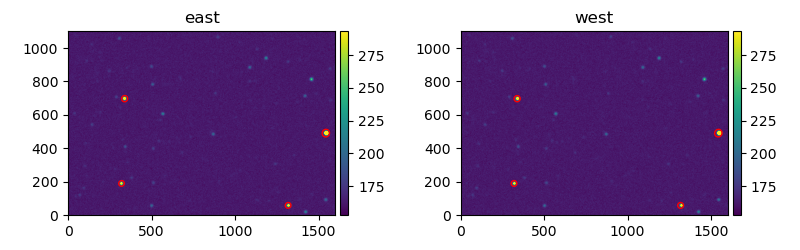

 focus: 41.06666666666666 file: ['/data/lvm/sci/agcam/east/20221108/lvm.sci.agcam.east_00000933.fits', '/data/lvm/sci/agcam/west/20221108/lvm.sci.agcam.west_00000933.fits']


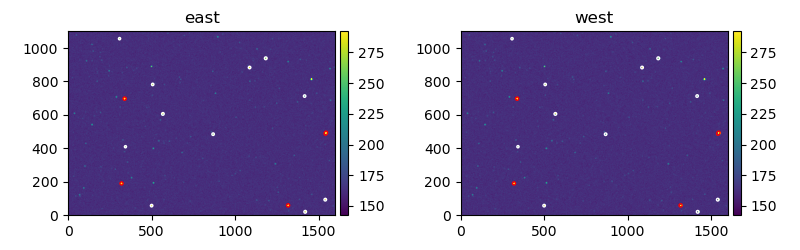

 focus: 41.9 file: ['/data/lvm/sci/agcam/east/20221108/lvm.sci.agcam.east_00000934.fits', '/data/lvm/sci/agcam/west/20221108/lvm.sci.agcam.west_00000934.fits']


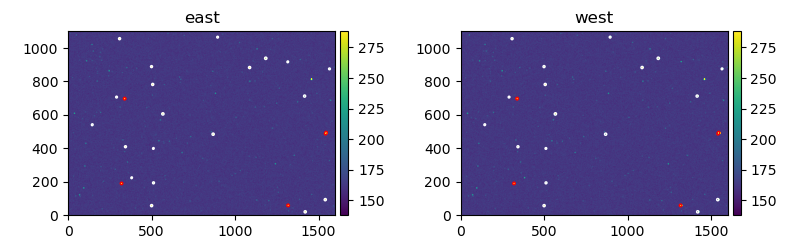

 focus: 42.733333333333334 file: ['/data/lvm/sci/agcam/east/20221108/lvm.sci.agcam.east_00000935.fits', '/data/lvm/sci/agcam/west/20221108/lvm.sci.agcam.west_00000935.fits']


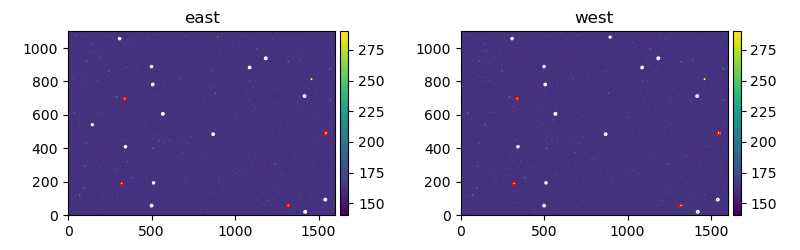

 focus: 43.56666666666666 file: ['/data/lvm/sci/agcam/east/20221108/lvm.sci.agcam.east_00000936.fits', '/data/lvm/sci/agcam/west/20221108/lvm.sci.agcam.west_00000936.fits']


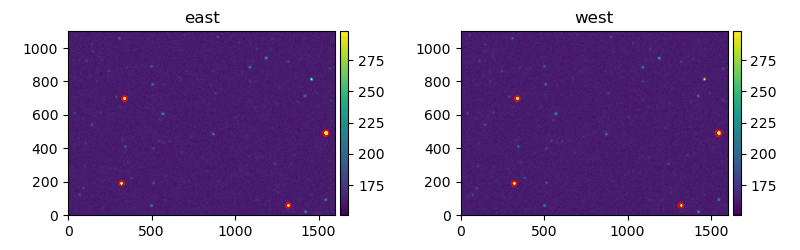

 focus: 44.4 file: ['/data/lvm/sci/agcam/east/20221108/lvm.sci.agcam.east_00000937.fits', '/data/lvm/sci/agcam/west/20221108/lvm.sci.agcam.west_00000937.fits']


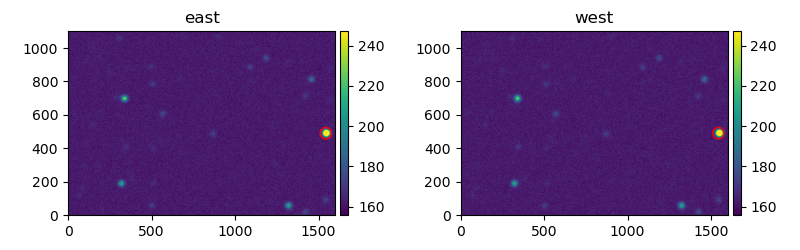

focus: 41.978975404852264, 0.0035333599910545186
focus: 41.978975404852264, 0.0035333599910545186


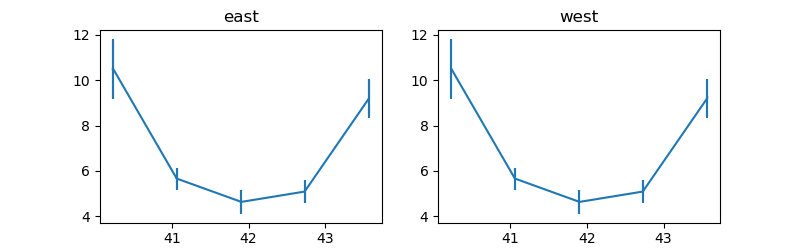

In [141]:
%matplotlib widget

from lvmtipo.actors import lvm

focus_guess=41.4
threshold = 12.0
minarea = 24.0
deblend_nthresh = 1.4

source_detection = SepSourceDetection(threshold= threshold, minarea=minarea, deblend_nthresh=deblend_nthresh)

await lvm.sci.pwi.start()
await lvm.sci.pwi.status()
await lvm.sci.foc.start()
await lvm.sci.foc.status()

await lvm.sci.agc.start()

radius_data = None


for focus in np.linspace(focus_guess-2.0, focus_guess+3.0, num=7):
    await lvm.sci.foc.moveAbsolute(focus, "DT")    
    filenames = (await lvm.sci.agc.expose(2.0)).flatten().unpack("*.filename")
    print(f" focus: {focus} file: {filenames}")
    images = [Image.from_file(f) for f in filenames]

    if not radius_data: radius_data = [list()]*len(images)
    await focus_calc(focus, radius_data, images, source_detection)

focus_plot(images, radius_data)